In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.model_selection import cross_val_score

path = 'dataset'
trainPath = os.path.join(path, 'train.csv')
testPath = os.path.join(path, 'test.csv')
outPath = 'out'
modelPath = 'model'

train = pd.read_csv(trainPath)
test = pd.read_csv(testPath)
sample = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

def outCsv(sample, fileName):
    sample.to_csv(os.path.join(outPath, fileName), index=False)

def outModel(model, fileName):
    joblib.dump(model, os.path.join(modelPath, fileName))





### 数据探索

In [2]:
print(train.columns)
print(train.columns.shape)
feature = train.drop(columns=['id', 'FloodProbability']).columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')
(22,)


In [3]:
print('train set null values: ', train.isnull().any().sum())
print('test set null values: ', test.isnull().any().sum())

train set null values:  0
test set null values:  0


In [4]:
print(train.shape)
print(test.shape)

(1117957, 22)
(745305, 21)


In [5]:
train.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


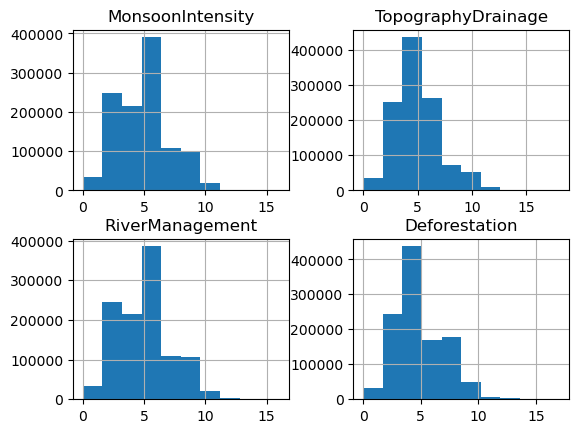

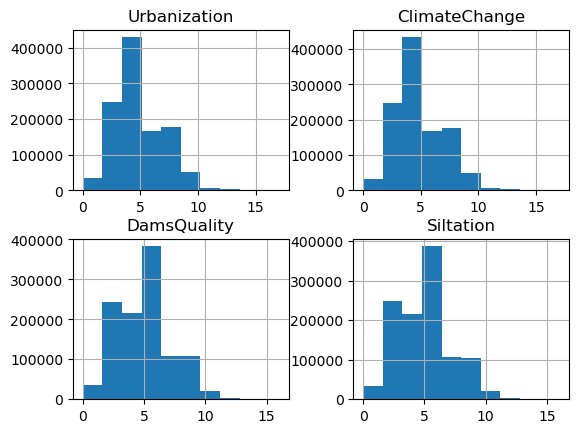

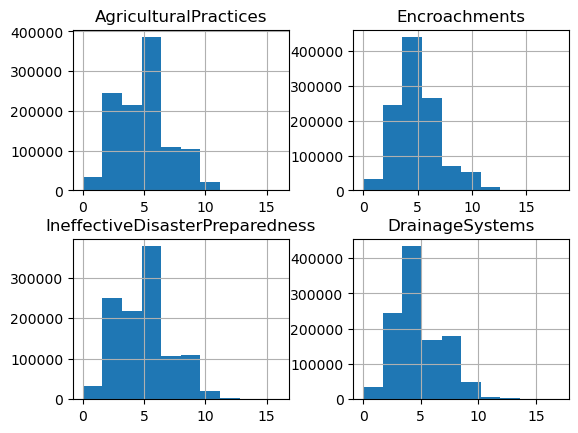

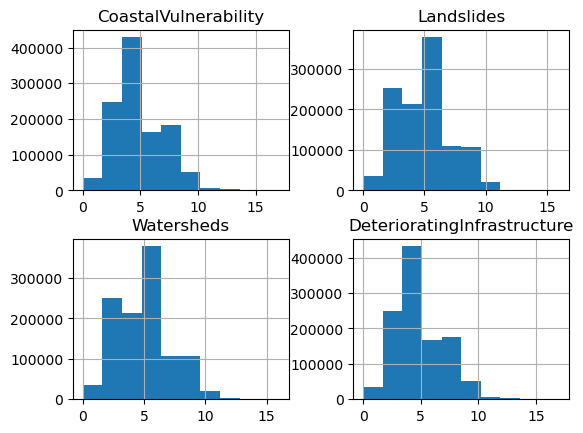

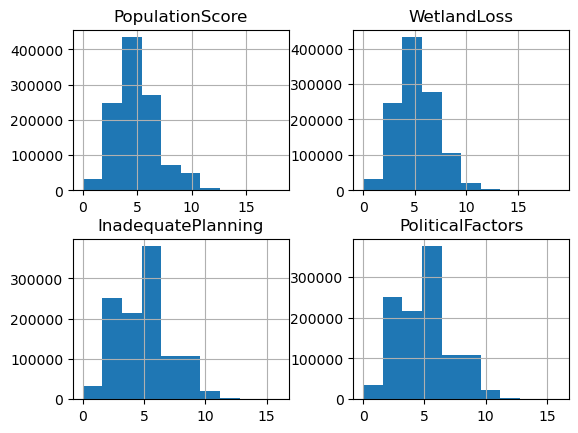

In [6]:
for col in range(5):
    train[feature[ col*4: (col+1)*4 ]].hist()
    plt.savefig(os.path.join(outPath, f'hist_{col}' + ".svg"))

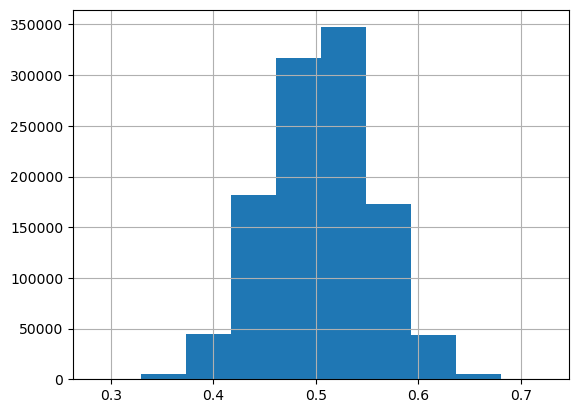

In [7]:
train['FloodProbability'].hist()
plt.savefig(os.path.join(outPath, 'hist_5.svg'))

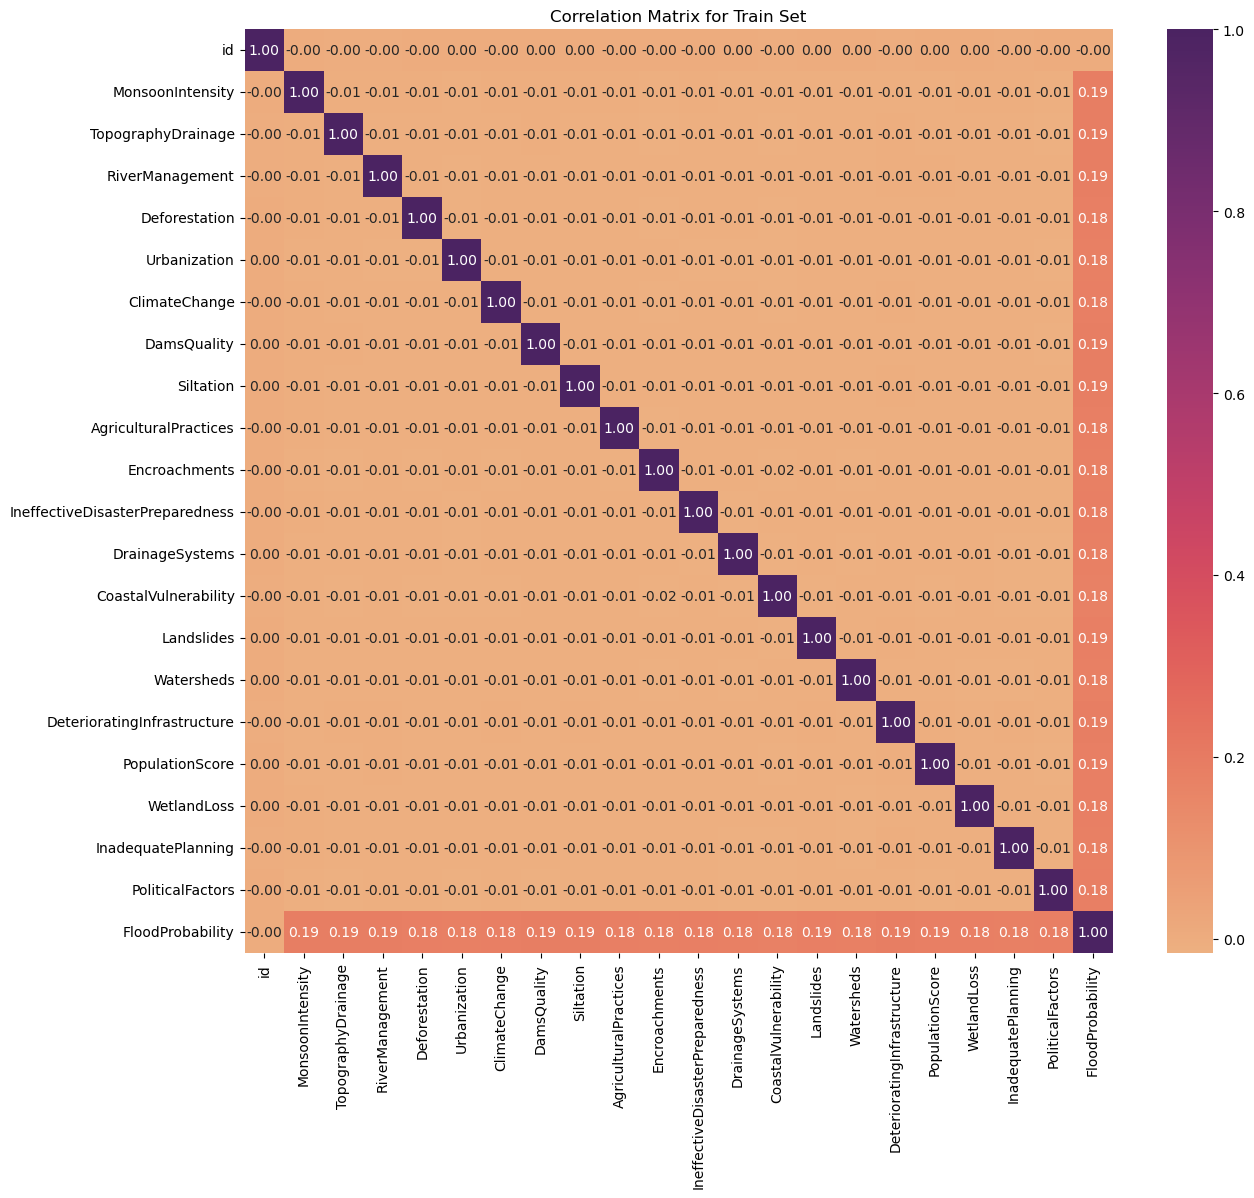

In [8]:
plt.figure(figsize=(14, 12))
corr_mat = train.corr()
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap='flare', cbar=True)
plt.title('Correlation Matrix for Train Set')

plt.savefig(os.path.join(outPath, "corrMat.svg"))

### 数据预处理

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

full_pipeline = Pipeline([
    ('stdScaler', StandardScaler()),
    ('minmaxScaler', MinMaxScaler())
])

X_train = full_pipeline.fit_transform(train[feature])
y_train = train['FloodProbability'].to_numpy()

X_test = full_pipeline.transform(test[feature])

### 模型训练

采用随机森林

In [52]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=35, n_jobs=-1)

rf_model.fit(X_train, y_train)


MemoryError: could not allocate 134217728 bytes

In [ ]:
y_pred_rf = rf_model.predict(X_test)

In [ ]:
sample['FloodProbability'] = y_pred_rf
outCsv(sample, 'sample_randomForest.csv')

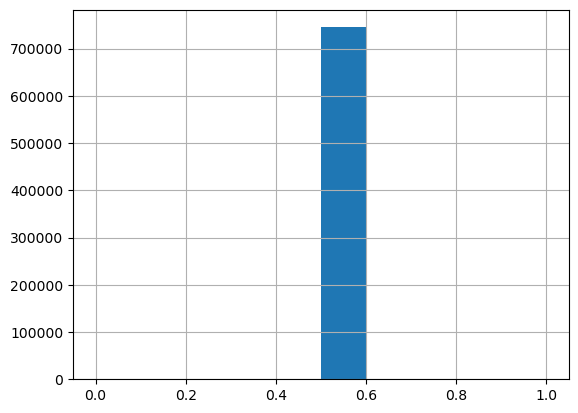

In [ ]:
sample['FloodProbability'].hist()
plt.savefig(os.path.join(outPath, 'rf_model.svg'))

In [ ]:
score_r2 = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=5, n_jobs=4)
print(score_r2)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\ensemble\_forest.py", line 456, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\utils\parallel.py", line 65, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\joblib\parallel.py", line 1098, in __call__
    self.retrieve()
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\joblib\parallel.py", line 975, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\multiprocessing\pool.py", line 774, in get
    raise self._value
  File "d:\tool\Anconda\envs\ML\Lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\joblib\_parallel_backends.py", line 620, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\joblib\parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\joblib\parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\utils\parallel.py", line 127, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\ensemble\_forest.py", line 188, in _parallel_build_trees
    tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\tree\_classes.py", line 1320, in fit
    super()._fit(
  File "d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\tree\_classes.py", line 443, in _fit
    builder.build(self.tree_, X, y, sample_weight, missing_values_in_feature_mask)
  File "sklearn\tree\_tree.pyx", line 165, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 266, in sklearn.tree._tree.DepthFirstTreeBuilder.build
  File "sklearn\tree\_tree.pyx", line 787, in sklearn.tree._tree.Tree._add_node
  File "sklearn\tree\_tree.pyx", line 757, in sklearn.tree._tree.Tree._resize_c
  File "sklearn\tree\_utils.pyx", line 37, in sklearn.tree._utils.safe_realloc
MemoryError: could not allocate 67108864 bytes


随机森林得到 0.66287 public score

试一下线性回归？

弹性网络开始

In [10]:
param_grid_net = {
    'alpha': np.arange(0.1, 0.5, 0.1),
    'l1_ratio' : np.arange(0.1, 1, 0.1),
    'max_iter' : [500, 1000]
    }
scoreing = 'r2'

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
gird_search_net = GridSearchCV(estimator=elastic_net, param_grid=param_grid_net,
                               scoring=scoreing, cv=3, verbose=True)
gird_search_net.fit(X_train, y_train)

print(gird_search_net.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
{'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 500}


In [11]:
best_parm_net = gird_search_net.best_params_
elastic_net = ElasticNet(alpha=0,
                         l1_ratio=0.01)
elastic_net.fit(X_train, y_train)


d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
d:\tool\Anconda\envs\ML\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+02, tolerance: 2.911e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_d

ElasticNet(alpha=0, l1_ratio=0.01)

In [12]:
score_r2 = cross_val_score(elastic_net, X_train, y_train, scoring='r2', cv=5, n_jobs=4)
print(score_r2)

[0.84510506 0.84337124 0.84461072 0.84660745 0.8449891 ]


In [13]:
y_pred_net = elastic_net.predict(X_test)

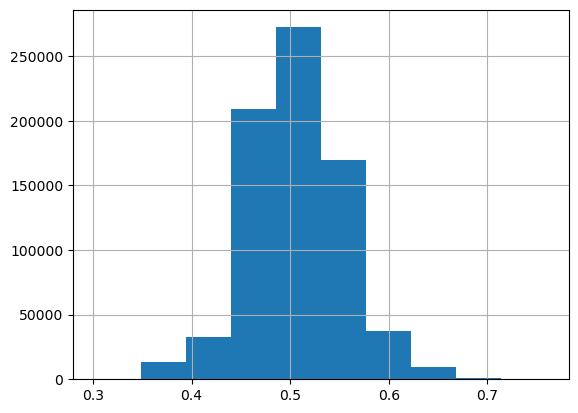

In [14]:
sample['FloodProbability'] = y_pred_net
sample['FloodProbability'].hist()
plt.savefig(os.path.join(outPath, 'net_model.svg'))

In [21]:
outCsv(sample, 'sample_Enet.csv')
outModel(elastic_net, "elastic_net.pkl")

可以看出网格搜索的 ``l1_ratio`` 十分接近0 (倾向于l2 penalty)，那我们为什么不试一试岭回归？

In [16]:
from sklearn.linear_model import Ridge

param_rg = {'alpha': np.arange(0.3, 1.11, 0.1),
            'solver': ['svd', 'cholesky', 'sag']}
scoreing = 'r2'

rg_model = Ridge()
grid_rg = GridSearchCV(rg_model, param_rg, scoring=scoreing, cv=5, n_jobs=4)
grid_rg.fit(X_train, y_train)

print(grid_rg.best_params_)

{'alpha': 0.5, 'solver': 'sag'}


In [17]:
best_parm_rg = grid_rg.best_params_
rg_model = Ridge(alpha=best_parm_rg['alpha'], solver=best_parm_rg['solver'])
rg_model.fit(X_train, y_train)

Ridge(alpha=0.5, solver='sag')

In [18]:
score_r2 = cross_val_score(rg_model, X_train, y_train, scoring='r2', cv=5, n_jobs=4)
print(score_r2)

[0.845105   0.84337122 0.84461065 0.84660738 0.84498925]


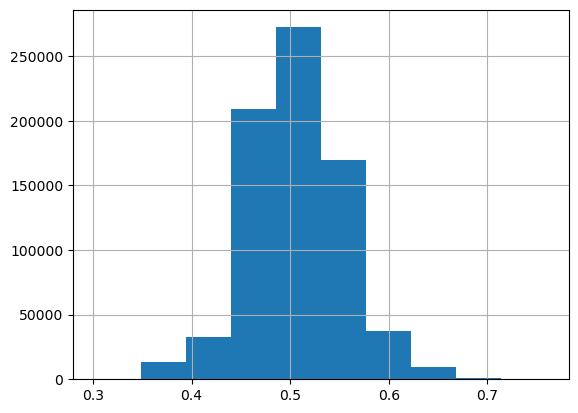

In [19]:
y_pred_rg = rg_model.predict(X_test)
sample['FloodProbability'] = y_pred_rg

sample['FloodProbability'].hist()
plt.savefig(os.path.join(outPath, 'ridge.svg'))

In [20]:
outCsv(sample, 'sample_ridge.csv')
outModel(rg_model, "ridge.pkl")

## 下面的内容仅测试

试一下集成学习能不能提高R2分数？

先从 AdaBoost 开始

In [25]:
# from sklearn.ensemble import AdaBoostRegressor

# ada_reg = AdaBoostRegressor(
#     rg_model, n_estimators=20,
#     loss='linear', learning_rate=0.5)

# ada_reg.fit(X_train, y_train)
# print(r2_score(y_train, ada_reg.predict(X_train)))
# y_pred_ada = ada_reg.predict(X_test)

0.8393886009765373


好像还没岭回归高

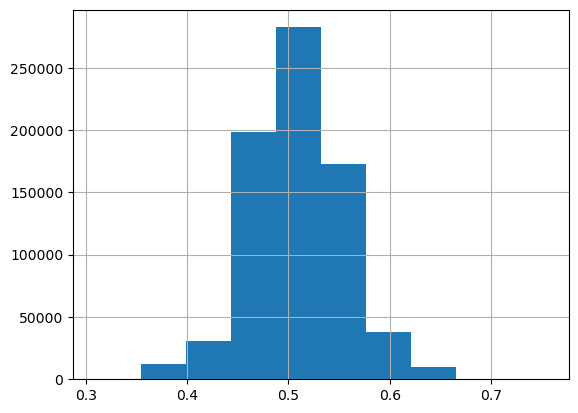

In [26]:
# sample['FloodProbability'] = y_pred_ada
# sample['FloodProbability'].hist()

# outCsv(sample, 'sample_ada.csv')

由于数据很集中，我想测试下，不标准化直接训练

In [45]:
grid_rg = GridSearchCV(Ridge(), param_rg, scoring=scoreing, cv=5, n_jobs=4)
grid_rg.fit(train[feature], train['FloodProbability'])
grid_rg.best_params_

{'alpha': 0.6000000000000001, 'solver': 'sag'}

In [46]:
best_parm_rg = grid_rg.best_params_
rg_model = Ridge(alpha=best_parm_rg['alpha'], solver=best_parm_rg['solver'])
rg_model.fit(train[feature], train['FloodProbability'])
print(r2_score(train['FloodProbability'], rg_model.predict(train[feature])))

0.8449501041063252


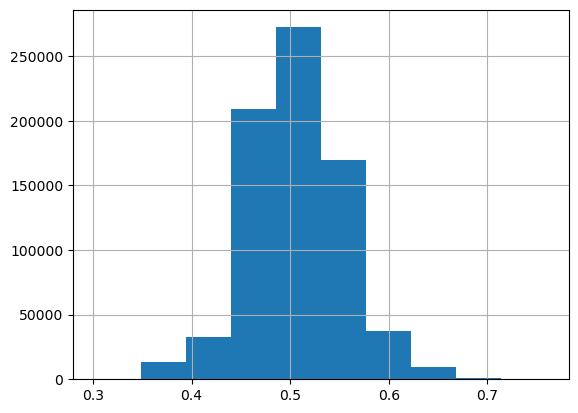

In [47]:
y_pred_rg = rg_model.predict(test[feature])
sample['FloodProbability'] = y_pred_rg

sample['FloodProbability'].hist()
outCsv(sample, 'sample_ridge_nodeal.csv')

此处平台提交分数和ridge回归一样